In [82]:
!pip3 install tensorflow_addons
!pip3 install tensorflow_datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Tensorflow dependencies ###
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

### Required for semi-hard triplet loss ###
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

In [83]:
def normalize_image(images):
  images = (images - 127.5) / 127.5
  images = images.astype(np.float32)

  return images

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train, X_test = normalize_image(X_train), normalize_image(X_test)
Y_train = Y_train.astype(np.float32)
Y_test = Y_test.astype(np.float32)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

x_train, y_train = next(iter(train_dataset))
print(y_train)

tf.Tensor([8 2 3 7 8 7 8 5 9 1 8 1 4 3 1 5 9 7 5 5 4 5 7 0 8 9 2 4 1 7 8 5], shape=(32,), dtype=int64)


In [90]:
def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

def masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
        math_ops.multiply(data - axis_minimums, mask), dim,
        keepdims=True) + axis_minimums
    return masked_maximums

def masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
        math_ops.multiply(data - axis_maximums, mask), dim,
        keepdims=True) + axis_maximums
    return masked_minimums

def triplet_loss_adapted_from_tf(y_true, y_pred):
    del y_true
    margin = 1.2
    labels = y_pred[:, :1]

 
    labels = tf.cast(labels, dtype='int32')

    embeddings = y_pred[:, 1:]

    ### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
    
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    # lshape=array_ops.shape(labels)
    # assert lshape.shape == 1
    # labels = array_ops.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=True)
    # Build pairwise binary adjacency matrix.
    adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = math_ops.logical_not(adjacency)

    # global batch_size  
    batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

    # Compute the mask.
    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
        array_ops.tile(adjacency_not, [batch_size, 1]),
        math_ops.greater(
            pdist_matrix_tile, array_ops.reshape(
                array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
        math_ops.greater(
            math_ops.reduce_sum(
                math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
            0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = array_ops.reshape(
        masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = array_ops.tile(
        masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
        mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
        adjacency, dtype=dtypes.float32) - array_ops.diag(
        array_ops.ones([batch_size]))

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = math_ops.reduce_sum(mask_positives)

    semi_hard_triplet_loss_distance = math_ops.truediv(
        math_ops.reduce_sum(
            math_ops.maximum(
                math_ops.multiply(loss_mat, mask_positives), 0.0)),
        num_positives,
        name='triplet_semihard_loss')
    
    ### Code from Tensorflow function semi-hard triplet loss ENDS here.
    return semi_hard_triplet_loss_distance


In [92]:
def get_model():
  inputs = Input(shape=(28,28,1))
  label_inputs = Input(shape=(1,))
  x = Conv2D(64, kernel_size=2, padding='same', activation='relu')(inputs)
  x = MaxPooling2D((2,2))(x)
  x = Dropout(0.3)(x)
  x = Conv2D(32, kernel_size=2, padding='same', activation='relu')(x)
  x = MaxPooling2D((2,2))(x)
  x = Dropout(0.3)(x)
  x = Flatten()(x)

  emb = Dense(128, name='embedding')(x)
  emb_norm = Lambda(lambda x : tf.math.l2_normalize(x, axis=1), name='normalized_embedding')(emb)
  labels_plus_embeddings = concatenate([label_inputs, emb], name='labels_and_embs')

  # output = Dense(10, name='probability')(emb)
  model = Model(inputs=[inputs, label_inputs], outputs=[labels_plus_embeddings, emb_norm], name='TripletLoss_Softmax')
  return model

losses = {
    # 'probability' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'normalized_embedding' : tfa.losses.TripletSemiHardLoss(distance_metric='angular', margin=0.5),
    'labels_and_embs' : triplet_loss_adapted_from_tf
}

train_targets = {
    # 'probability' : Y_train,
    'normalized_embedding' : Y_train,
    'labels_and_embs' : Y_train
}

val_targets = {
    # 'probability' : Y_test,
    'normalized_embedding' : Y_test,
    'labels_and_embs' : Y_test
}

model = get_model()
model.compile(optimizer=Adam(lr=0.00001), loss=losses)
print(model.summary())

Model: "TripletLoss_Softmax"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 28, 28, 64)   320         input_25[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_38 (MaxPooling2D) (None, 14, 14, 64)   0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 14, 14, 64)   0           max_pooling2d_38[0][0]           
________________________________________________________________________________

In [93]:
history = model.fit([X_train, Y_train], Y_train, validation_data=([X_test, Y_test], Y_test), epochs=10, batch_size=64)

Epoch 1/10
938/938 [==============================] - 13s 12ms/step - loss: 1.5804 - labels_and_embs_loss: 1.0848 - normalized_embedding_loss: 0.4956 - val_loss: 1.3254 - val_labels_and_embs_loss: 0.8626 - val_normalized_embedding_loss: 0.4628
Epoch 2/10
938/938 [==============================] - 11s 12ms/step - loss: 1.3838 - labels_and_embs_loss: 0.8978 - normalized_embedding_loss: 0.4861 - val_loss: 1.0194 - val_labels_and_embs_loss: 0.5795 - val_normalized_embedding_loss: 0.4399
Epoch 3/10
938/938 [==============================] - 11s 12ms/step - loss: 1.1220 - labels_and_embs_loss: 0.6492 - normalized_embedding_loss: 0.4728 - val_loss: 0.8594 - val_labels_and_embs_loss: 0.4328 - val_normalized_embedding_loss: 0.4266
Epoch 4/10
938/938 [==============================] - 11s 12ms/step - loss: 0.9590 - labels_and_embs_loss: 0.4973 - normalized_embedding_loss: 0.4617 - val_loss: 0.7647 - val_labels_and_embs_loss: 0.3515 - val_normalized_embedding_loss: 0.4132
Epoch 5/10
938/938 [====

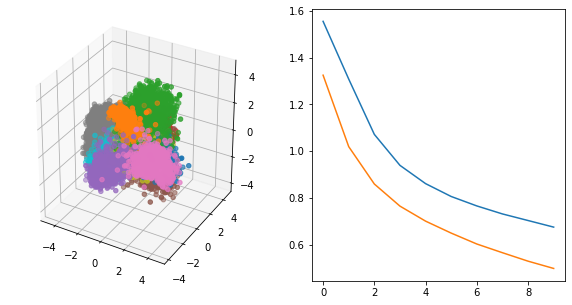

In [96]:
embedder = Model(inputs=model.inputs[0], outputs=model.get_layer("embedding").output)
test_embs = embedder.predict(X_test)
# test_embs /= np.linalg.norm(test_embs, axis=1, keepdims=True)
test_embs = PCA(n_components=3).fit_transform(test_embs)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for label in np.unique(Y_test):
  cluster = test_embs[Y_test == label]
  ax.scatter(cluster[:,0], cluster[:, 1], cluster[:,2])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
plt.show()

In [88]:
!nvidia-smi

Fri May  7 10:32:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    68W / 149W |    413MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------